561 Project code implementation

In [1]:
import numpy as np 
import random
import matplotlib.pyplot as plt 
import math 
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import os
import seaborn as sns
import copy

from torch.distributions.multivariate_normal import MultivariateNormal

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### BatchNorm Implementation

In [3]:
class BatchNorm(nn.Module):
    def __init__ (self, dim, momentum=0.9, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.zeros(1, dim))
        self.beta = nn.Parameter(torch.zeros(1, dim))
        self.momentum = momentum

        self.register_buffer('running_mean',torch.zeros(dim))
        self.register_buffer('running_var',torch.ones(dim))

        
    def forward(self,x):
        if self.training:
            self.mean = x.mean(dim=0)
            self.running_mean.mul_(self.momentum).add_(self.mean.data*(1-self.momentum))
            self.var = x.var(dim=0,unbiased=False)
            self.running_var.mul_(self.momentum).add_(self.var.data*(1-self.momentum))

            mean = self.mean
            var = self.var
        else:
            mean = self.running_mean
            var = self.running_var
        
        # According to section 3.7 NVP & MAF EQN22
        x_hat = (x-mean)/torch.sqrt(var+self.eps)
        u = x_hat * torch.exp(self.gamma) + self.beta
        
        # According to MAF EQN23
        log_det = self.gamma - 0.5 * torch.log(var+self.eps)
        
        return u, log_det
    
    
    def reverse(self,u):
        if self.training:
            mean = x.mean(dim=0)
            var = x.var(dim=0,unbiased=False)
        else:
            mean = self.running_mean
            var = self.running_var

        x_hat = (u-self.beta)*torch.exp(-self.gamma)
        x = x_hat * torch.sqrt(var+self.eps)+mean

        log_det = 0.5 * torch.log(var + self.eps) - self.gamma
        
        return x, log_det

In [5]:
class Affine_Coupling(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden, mask, cond_label_size=None):
        super().__init__()
        # initiate the mask
        self.register_buffer('mask', mask)
        s_net = [nn.Linear(input_size, hidden_size)]
        for _ in range(n_hidden):
            s_net += [nn.ReLU(), nn.Linear(hidden_size, hidden_size)]
        s_net += [nn.ReLU(), nn.Linear(hidden_size, input_size)]
        # NN to train the S parameter
        self.s_net = nn.Sequential(*s_net)
        # NN to train the T parameter
        self.t_net = copy.deepcopy(self.s_net)
        
    def forward(self, x):
        # input x according to masks
        mx = x * self.mask
        s = self.s_net(mx)
        t = self.t_net(mx)
        u = mx + (1 - self.mask) * (x - t) * torch.exp(-s)
        log_abs_det_jacobian = - (1 - self.mask) * s
        return u, log_abs_det_jacobian

    def reverse(self, u):
        # reverse operation
        mu = u * self.mask
        s = self.s_net(mu)
        t = self.t_net(mu)
        x = mu + (1 - self.mask) * (u * s.exp() + t)

        log_abs_det_jacobian = (1 - self.mask) * s

        return x, log_abs_det_jacobian

class RealNVP(nn.Module):
    def __init__(self, n_blocks, input_size, hidden_size, n_hidden):
        super().__init__()
        
        # initiate mean and variance as 0 and 1 for the distribution we want to transform to 
        self.register_buffer('base_dist_mean', torch.zeros(input_size))
        self.register_buffer('base_dist_var', torch.ones(input_size))
        
        # initiate Affine Coupling Layer and BatchNorm
        modules = []
        for _ in range(n_blocks):
            mask = torch.ones(input_size).int()
            m_length = 0
            i = 0
            mask_set = []
            while True:
                i += 1
                m_length += math.ceil(input_size * (1 / 2)**i)
                tmp = copy.deepcopy(mask)
                tmp[:m_length] = 0
                mask_set.append(tmp.int())
                modules += [
                    Affine_Coupling(input_size, hidden_size, n_hidden, tmp.int()),
                    BatchNorm(input_size),
                ]
                if torch.sum(tmp.int()) == 1:
                    break
            # print(mask_set)
            for m in reversed(mask_set):
                mask_sym = torch.flip(m, [0])
                modules += [
                    Affine_Coupling(input_size, hidden_size, n_hidden, mask_sym.int()),
                    BatchNorm(input_size),
                ]

        self.net = nn.Sequential(*modules)


    @property
    def base_dist(self):
        # Base distribution
        return torch.distributions.Normal(self.base_dist_mean, self.base_dist_var)

    def forward(self, x):
        # Forward Pass, reshape x because x could be a 3d tensor
        x = x.view(x.shape[0], -1)
        log_det_sum = 0
        for module in self.net:
            x, log_det = module(x)
            log_det_sum = log_det_sum + log_det
        return x, log_det_sum

    def reverse(self, u):
        # reverse transform 
        log_det_sum = 0
        for module in reversed(self.net):
            u, log_det = module.reverse(u)
            log_det_sum = log_det_sum + log_det
        return u, log_det_sum    

In [6]:
from sklearn.datasets import make_circles, make_moons

In [7]:
hidden_dim = 128
realNVP = RealNVP(5,2,hidden_dim,3).to(device)
optimizer = optim.Adam(realNVP.parameters(), lr = 0.001)


Epochs = 1000
realNVP.train()
for epoch in range(Epochs):
    x, label = make_moons(n_samples = 1000, noise = 0.02)
    x = torch.Tensor(x).to(device)
    z, log_det = realNVP(x)
    loss = -torch.sum(realNVP.base_dist.log_prob(z) + log_det, dim=1).mean(0)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        print(f"Trained Epoch {epoch+1}: loss = {loss.item()}")

Trained Epoch 100: loss = -0.2814788222312927
Trained Epoch 200: loss = -0.5734021067619324
Trained Epoch 300: loss = -0.50155109167099
Trained Epoch 400: loss = -0.5443322658538818
Trained Epoch 500: loss = -0.5539378523826599
Trained Epoch 600: loss = -0.5783737897872925
Trained Epoch 700: loss = -0.5578786134719849
Trained Epoch 800: loss = -0.5919544696807861
Trained Epoch 900: loss = -0.5622031688690186
Trained Epoch 1000: loss = -0.5375468730926514


In [9]:
hidden_dim = 128
realNVP = RealNVP(5,2,hidden_dim,3).to(device)
optimizer = optim.Adam(realNVP.parameters(), lr = 0.001)

Epochs = 1000
realNVP.train()
for epoch in range(Epochs):
    x, label = make_circles(n_samples = 1000, noise = 0.02)
    x = torch.Tensor(x).to(device)
    z, log_det = realNVP(x)
    loss = -torch.sum(realNVP.base_dist.log_prob(z) + log_det, dim=1).mean(0)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        print(f"Trained Epoch {epoch+1}: loss = {loss.item()}")

Trained Epoch 100: loss = 0.8373213410377502
Trained Epoch 200: loss = 0.7867103219032288
Trained Epoch 300: loss = 0.5938005447387695
Trained Epoch 400: loss = 0.5102494955062866
Trained Epoch 500: loss = 0.4842654764652252
Trained Epoch 600: loss = 0.5001676082611084
Trained Epoch 700: loss = 0.46076807379722595
Trained Epoch 800: loss = 0.40771400928497314
Trained Epoch 900: loss = 0.5853369235992432
Trained Epoch 1000: loss = 0.6771484613418579


In [10]:
batch_size_train = 1000
train_set = torchvision.datasets.KMNIST('KMNIST/raw/train-images-idx3-ubyte', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize(16),
                               torchvision.transforms.ToTensor()
                             ]))

train_loader_KMNIST = torch.utils.data.DataLoader(train_set, batch_size=batch_size_train, shuffle=True)

  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting KMNIST/raw/train-images-idx3-ubyte/KMNIST/raw/train-images-idx3-ubyte.gz to KMNIST/raw/train-images-idx3-ubyte/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting KMNIST/raw/train-images-idx3-ubyte/KMNIST/raw/train-labels-idx1-ubyte.gz to KMNIST/raw/train-images-idx3-ubyte/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting KMNIST/raw/train-images-idx3-ubyte/KMNIST/raw/t10k-images-idx3-ubyte.gz to KMNIST/raw/train-images-idx3-ubyte/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting KMNIST/raw/train-images-idx3-ubyte/KMNIST/raw/t10k-labels-idx1-ubyte.gz to KMNIST/raw/train-images-idx3-ubyte/KMNIST/raw



torch.Size([1000, 1, 16, 16])


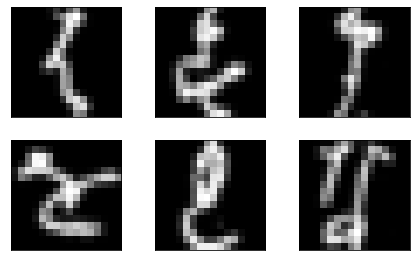

In [11]:
examples = enumerate(train_loader_KMNIST)
batch_idx, (example_data,_) = next(examples)
print(example_data.shape)
fig = plt.figure()
for i in range(min(example_data.shape[0],6)):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow((example_data[i][0]), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    fig

In [12]:
batch_size_train = 1000
train_set = torchvision.datasets.USPS('USPS', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize(16),
                               torchvision.transforms.ToTensor()
                             ]))

train_loader_USPS = torch.utils.data.DataLoader(train_set, batch_size=batch_size_train, shuffle=True)

  0%|          | 0/6579383 [00:00<?, ?it/s]

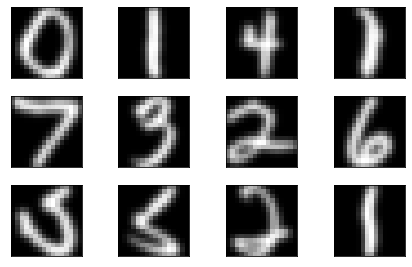

In [21]:
examples = enumerate(train_loader_USPS)
batch_idx, (example_data) = next(examples)
fig = plt.figure()
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.tight_layout()
    plt.imshow((example_data[0][i][0]), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    fig

Trained Epoch 25: loss = -843.0462646484375


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


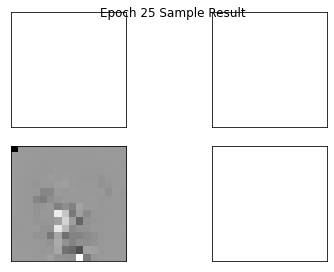

Trained Epoch 50: loss = -1048.078125


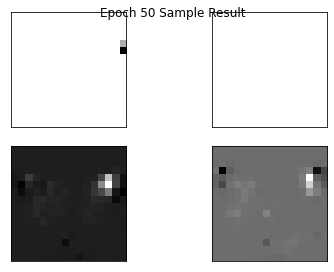

Trained Epoch 75: loss = -1071.4827880859375


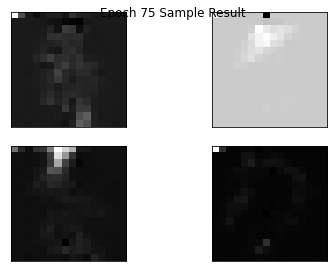

In [34]:
hidden_dim = 256
input_dim = train_set[0][0].shape[1]*train_set[0][0].shape[2]
nblock = 5
realNVP = RealNVP(nblock,input_dim,hidden_dim,3).to(device)
optimizer = optim.Adam(realNVP.parameters(), lr = 0.001)


Epochs = 80
realNVP.train()
for epoch in range(Epochs):
    for idx, (data, _) in enumerate(train_loader_KMNIST):
        x = data.to(device)
        z, log_det = realNVP(x)
        loss = -torch.sum(realNVP.base_dist.log_prob(z) + log_det, dim=1).mean(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1)%25 == 0:
        print(f"Trained Epoch {epoch+1}: loss = {loss.item()}")
        realNVP.eval()
        distrib = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
        z_gen = distrib.rsample(sample_shape=torch.Size([4])).to(device)
        x_gen, _ = realNVP.reverse(z_gen.reshape(z_gen.shape[0], 256))
        x_gen = x_gen.reshape(x_gen.shape[0], 16, 16)
        plt.figure()
        for i in range(4):
            plt.subplot(2,2,i+1)
            plt.tight_layout()
            plt.imshow((x_gen[i].cpu().detach().numpy()), cmap='gray', interpolation='none')
            plt.xticks([])
            plt.yticks([])
        plt.suptitle(f"Epoch {epoch+1} Sample Result")
        plt.show()
    realNVP.train()

In [33]:
torch.cuda.empty_cache()

Trained Epoch 16: loss = -679.2488403320312


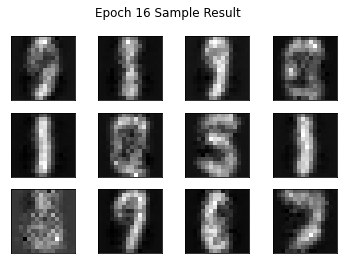

Trained Epoch 32: loss = -769.5353393554688


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


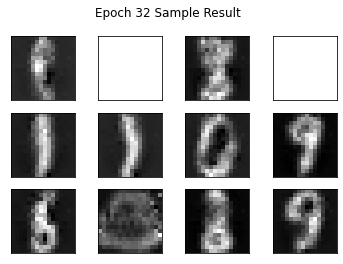

Trained Epoch 48: loss = -836.2598876953125


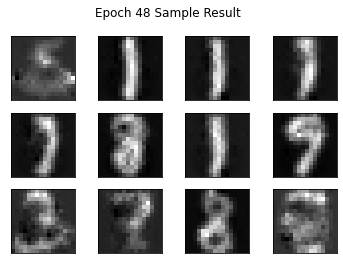

Trained Epoch 64: loss = -926.8760986328125


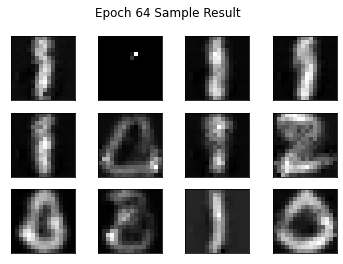

Trained Epoch 80: loss = -961.7860107421875


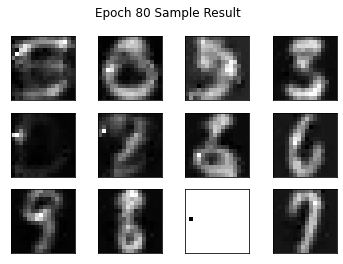

In [32]:
hidden_dim = 256
input_dim = train_set[0][0].shape[1]*train_set[0][0].shape[2]
nblock = 3
realNVP = RealNVP(nblock,input_dim,hidden_dim,3).to(device)
optimizer = optim.Adam(realNVP.parameters(), lr = 0.001)


Epochs = 80
realNVP.train()
for epoch in range(Epochs):
    for idx, (data, _) in enumerate(train_loader_USPS):
        x = data.to(device)
        z, log_det = realNVP(x)
        loss = -torch.sum(realNVP.base_dist.log_prob(z) + log_det, dim=1).mean(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1)%16 == 0:
        realNVP.eval()
        print(f"Trained Epoch {epoch+1}: loss = {loss.item()}")
        distrib = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
        z_gen = distrib.rsample(sample_shape=torch.Size([12])).to(device)
        x_gen, _ = realNVP.reverse(z_gen.reshape(z_gen.shape[0], 256))
        x_gen = x_gen.reshape(x_gen.shape[0], 16, 16)
        plt.figure()
        for i in range(12):
            plt.subplot(3,4,i+1)
            plt.imshow((x_gen[i].cpu().detach().numpy()), cmap='gray', interpolation='none')
            plt.xticks([])
            plt.yticks([])
        plt.suptitle(f"Epoch {epoch+1} Sample Result")
        plt.show()
    realNVP.train()